In [1]:
from AFM_lib import GenMaxwell_parabolic_LR
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import os
%matplotlib inline

path = os.getcwd()

## First mode results

In [2]:
k_m1 = 6.5
A1, A2, A3 = 230.0e-9, 0.0, 0.0
Q1, Q2, Q3 = 150.0, 300.0, 450.0
fo1 = 46.0e3
R = 10.0e-9

period1 = 1.0/fo1
dt = period1/10.0e3
startprint = 5.0*Q1*period1
simultime = startprint + 10.0*period1
printstep = period1/1.0e3

In [3]:
df_G = pd.read_csv('PIB.txt', delimiter='\t', header=None)
tau = df_G.iloc[:,0].values
G = df_G.iloc[:,1].values
Ge = 0.0
H = 2.0e-19

## Lee & Radok simulation

In [4]:
os.chdir(path + '/1stMode')
zb = A1
GenMaxwell_jit = jit()(GenMaxwell_parabolic_LR)
while zb > -100.0e-9:
    %time t, tip, Fts, xb = GenMaxwell_jit(G, tau, R, dt, startprint, simultime, fo1, k_m1, A1, A2, A3, zb, printstep, Ge, Q1, Q2, Q3, H)
    name = str(int(zb*1.0e9)) + '.txt'
    np.savetxt('%s'%name, np.array((t*1.0e6, tip*1.0e9, Fts*1.0e9, xb*1.0e9)).T, delimiter='\t', header = 'time(us)\ttip(nm)\tFts(nN)\tXb(nm)')
    zb = zb - 10.0e-9

Wall time: 17.4 s
Wall time: 30.6 s
Wall time: 28.5 s
Wall time: 26.1 s
Wall time: 27.7 s
Wall time: 31.5 s
Wall time: 30.4 s
Wall time: 36 s
Wall time: 35.2 s
Wall time: 34.2 s
Wall time: 36.8 s
Wall time: 37.5 s
Wall time: 33.7 s
Wall time: 37.8 s
Wall time: 30.5 s
Wall time: 35.2 s
Wall time: 35.1 s
Wall time: 31.1 s
Wall time: 29.8 s
Wall time: 30.8 s
Wall time: 32.7 s
Wall time: 32.1 s
Wall time: 30.9 s
Wall time: 29.5 s
Wall time: 33 s
Wall time: 29.1 s
Wall time: 29.7 s
Wall time: 29.6 s
Wall time: 32.4 s
Wall time: 31.1 s
Wall time: 29.4 s
Wall time: 30.5 s
Wall time: 34.1 s


## Postprocessing Calculations

In [5]:
from glob import glob
os.chdir(path)
from AFM_calculations import av_dt, Amp_Phase, E_diss, V_ts, Ediss_Tamayo, virial_Lozano

os.chdir(path + '/1stMode')
files = glob('*.txt')

zeq = []
peakF = []
maxdepth = []
amp = []
phase = []
Ediss = []
Ediss_tamayo = []
Vdiss_lozano = []
Vdiss = []

for i in files:
    res = np.loadtxt('%s'%i, skiprows=1)
    t = res[::10,0]*1.0e-6
    dt = av_dt(t)
    
    tip = res[::10,1]*1.0e-9
    A,phi = Amp_Phase(t, tip, fo1)
    Fts = res[::10,2]*1.0e-9
    Ets = E_diss(tip, Fts, dt, fo1)
    fts_peak = Fts[np.argmax(Fts)]
    xb = res[::10,3]*1.0e-9
    tip_depth = xb[np.argmax(tip)] -xb[np.argmin(tip)]
    zb = i.rstrip('.txt')
    Vts = V_ts(tip-float(zb)*1.0e-9, Fts, dt)
    Ets_tamayo = Ediss_Tamayo(k_m1, Q1, A1, A, phi)
    Vts_lozano = virial_Lozano(k_m1, Q1, A1, A, phi)
    
    #Attaching values to arrays
    zeq.append(float(int(zb)))
    peakF.append(fts_peak)
    maxdepth.append(tip_depth)
    amp.append(A)
    phase.append(phi)
    Ediss.append(Ets)
    Vdiss.append(Vts)
    Vdiss_lozano.append(Vts_lozano)
    Ediss_tamayo.append(Ets_tamayo)
    #plt.plot(t, tip)

zeq = np.array(zeq)
peakF= np.array(peakF)
maxdepth = np.array(maxdepth)
amp = np.array(amp)
phase = np.array(phase)
Ediss = np.array(Ediss)
Vdiss = np.array(Vdiss)
Vdiss_lozano = np.array(Vdiss_lozano)
Ediss_tamayo = np.array(Ediss_tamayo)

## Plotting and saving results

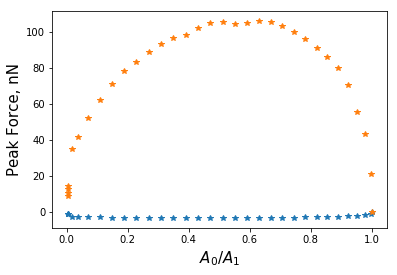

In [6]:
A1 = 230.0e-9   #amplitude of the 1st mode

os.chdir(path + '/1stMode')
plt.plot(amp/A1, -maxdepth*1.0e9, '*')
plt.xlabel('$A_0/A_1$', fontsize =15)
plt.ylabel('Maximum Penetration, nm', fontsize=15)
plt.savefig('Max_penetration.png', bbox_inches='tight')
plt.plot(amp/A1, peakF*1.0e9, '*')
plt.xlabel('$A_0/A_1$', fontsize =15)
plt.ylabel('Peak Force, nN', fontsize=15)
plt.savefig('Max_Force.png', bbox_inches='tight')

z_sort = np.sort(zeq)
index = np.argsort(zeq)
maxd = []
peakforce = []
amplitude = []
Ets = []
phi = []
Vts = []
Vts_lozano = []
Ets_tamayo = []
for i in index:
    maxd.append(maxdepth[i])
    peakforce.append(peakF[i])
    amplitude.append(amp[i])
    Ets.append(Ediss[i])
    phi.append(phase[i])
    Ets_tamayo.append(Ediss_tamayo[i])
    Vts.append(Vdiss[i])
    Vts_lozano.append(Vdiss_lozano[i])

maxd = np.array(maxd)
peakforce = np.array(peakforce)
amplitude = np.array(amplitude)
Ets = np.array(Ets)
phi = np.array(phi)
Ets_tamayo = np.array(Ets_tamayo)
Vts = np.array(Vts)
Vts_lozano = np.array(Vts_lozano)

np.savetxt('1stMode.txt', np.array((amplitude/A1, peakforce*1.0e9, -maxd*1.0e9, phi, Ets*1.0e18, Ets_tamayo*1.0e18, Vts*1.0e18, Vts_lozano*1.0e18 )).T, delimiter='\t', header = 'amp_ratio\tpeakF(nN)\tmaxdepth(nm)\tphase(deg)\tEdiss(aJ)\tEdiss_Tamayo(aJ)\tVts(aJ)\tVts_lozano(aJ)')


## MDR Simulation

In [ ]:
from AFM_lib import MDR_GenMaxwell_tapping

MDR_jit = jit()(MDR_GenMaxwell_tapping)
%time t_m, tip_m, Fts_m, xb_m = MDR_jit(G, tau, R, dt, simultime, zb, A1, k_m1, fo1, printstep, 1000, Ge, 5.0e-9, startprint, Q1, Q2, Q3, H, A2, A3)

In [ ]:
plt.plot(t_m, Fts_m, label='MDR')
plt.plot(time, Fts, label='L&R')
plt.legend(loc=1)

## Numerical Convolution

In [ ]:
from AFM_calculations import derivative_cd, av_dt

xb -= max(xb)
plt.plot(xb)


In [ ]:
xb_dot = derivative_cd( (-xb)**1.5, time)  #derivative of the sample displacement
G_rel = np.zeros(len(time))
for i in range(len(time)):
    G_rel[i] = Ge + sum(G[:]*np.exp(-time[i]/tau[:]))   #relaxation modulus of the generalized Wiechert Model
dt = av_dt(time)

conv = np.convolve(G_rel, xb_dot, mode='full')*dt #convolution of the relaxation modulus with the derivative of sample displacement
conv = conv[:len(xb)]


In [ ]:
alfa = 16.0/3.0*np.sqrt(R)
plt.plot( (tip)*1.0e9, Fts, 'b--', lw = 3, label = 'Fts_LRsimul')
plt.plot((tip)*1.0e9, conv*alfa, 'r', lw=1.0, label='convolution-LR')
plt.legend(loc=1)
plt.xlim(-30,10)

In [ ]:
plt.plot((tip)*1.0e9,conv*alfa)